## In this notebook, we will classify the logos (among 6 selected brands) based on the image of a logo.

## We will import all the required libraries

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

## Unzip the dataset so that we can use it in our notebook

In [8]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Sanskar__02/logos3.zip
!unzip -qo logos3.zip
# zip folder is not needed anymore
!rm logos3.zip

--2021-09-16 13:20:24--  https://cainvas-static.s3.amazonaws.com/media/user_data/Sanskar__02/logos3.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.72
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35080657 (33M) [application/zip]
Saving to: ‘logos3.zip’

logos3.zip          100%[===================>]  33.46M  78.6MB/s    in 0.4s    

2021-09-16 13:20:25 (78.6 MB/s) - ‘logos3.zip’ saved [35080657/35080657]



In [9]:
directory = "logos3/train"

### Map the classifications i.e. classes to an integer and display the list of all unique 6 brands.

In [10]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['Burger King', 'McDonalds', '.DS_Store', 'Other', 'Starbucks', 'Subway', 'KFC']
7


In [11]:
brand_map = dict(zip(Name, [t for t in range(len(Name))]))
print(brand_map)
r_brand_map=dict(zip([t for t in range(len(Name))],Name)) 

{'Burger King': 0, 'McDonalds': 1, '.DS_Store': 2, 'Other': 3, 'Starbucks': 4, 'Subway': 5, 'KFC': 6}


## Displaying some images from our dataset.

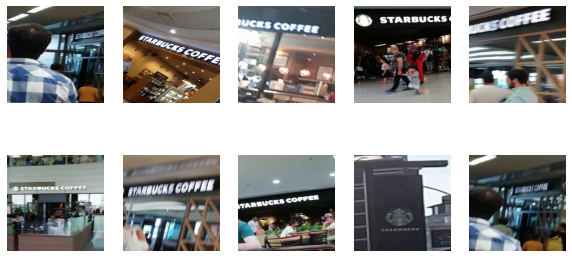

In [12]:
Brand = 'logos3/train/Starbucks'
import os 
sub_class = os.listdir(Brand)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(Brand,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [13]:
# def mapper(value):
#     return r_breed_map[value]

In [14]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                vertical_flip=True,
                                horizontal_flip=True,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.1,
                                validation_split=0.2)

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = img_datagen.flow_from_directory(directory,
                                                 shuffle=True,
                                                 batch_size=32,
                                                 subset='training',
                                                 target_size=(100, 100))

Found 1393 images belonging to 6 classes.


### Divide the training dataset into train set and validation set.

In [17]:
valid_generator = img_datagen.flow_from_directory(directory,
                                                 shuffle=True,
                                                 batch_size=16,
                                                 subset='validation',
                                                 target_size=(100, 100))

Found 345 images belonging to 6 classes.


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,Activation,BatchNormalization
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

## Train a sequential model.

In [19]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(6))
# model.add(Dense(len(brand_map)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        3

In [20]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [21]:
history = model.fit(train_generator, validation_data=valid_generator,batch_size= 32,epochs=50)

Epoch 1/50
44/44 [==============================] - 6s 127ms/step - loss: 1.5735 - accuracy: 0.4559 - val_loss: 1.4625 - val_accuracy: 0.4783
Epoch 2/50
44/44 [==============================] - 5s 122ms/step - loss: 1.4629 - accuracy: 0.4738 - val_loss: 1.3690 - val_accuracy: 0.4783
Epoch 3/50
44/44 [==============================] - 5s 122ms/step - loss: 1.2189 - accuracy: 0.5477 - val_loss: 1.1310 - val_accuracy: 0.5884
Epoch 4/50
44/44 [==============================] - 5s 121ms/step - loss: 1.0317 - accuracy: 0.6030 - val_loss: 1.0214 - val_accuracy: 0.6232
Epoch 5/50
44/44 [==============================] - 5s 122ms/step - loss: 1.0583 - accuracy: 0.5894 - val_loss: 1.0458 - val_accuracy: 0.6116
Epoch 6/50
44/44 [==============================] - 5s 122ms/step - loss: 1.0305 - accuracy: 0.6030 - val_loss: 1.2231 - val_accuracy: 0.5275
Epoch 7/50
44/44 [==============================] - 5s 121ms/step - loss: 0.9852 - accuracy: 0.6281 - val_loss: 1.0685 - val_accuracy: 0.6058
Epoch 

# Plot curves

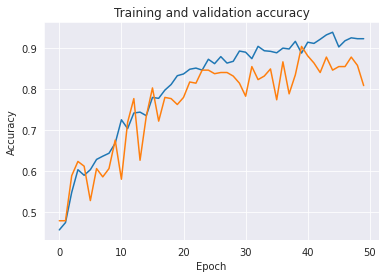

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.show()

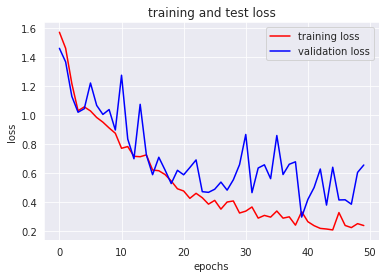

In [23]:
training_accuracy = history.history['loss']
validation_accuracy = history.history['val_loss']
plt.plot(training_accuracy, 'r', label = 'training loss')
plt.plot(validation_accuracy, 'b', label = 'validation loss')
plt.title('training and test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Making Predictions

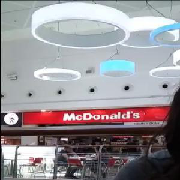

In [30]:
# from tensorflow.keras.models import load_img
from tensorflow.keras.preprocessing.image import load_img
load_img("logos3/test/McDonalds/armada_image_755.jpg",target_size=(180,180))

In [36]:
# from tensorflow.keras import image
from tensorflow.keras.preprocessing import image
test_image = image.load_img('logos3/test/KFC/armada_image_169.jpg', target_size = (100, 100))  
test_image = image.img_to_array(test_image)  
test_image = np.expand_dims(test_image, axis = 0)  
result = model.predict(test_image)  
print(result)

[[0. 1. 0. 0. 0. 0.]]


# Deep CC

In [37]:
model.save('saved_models/logos.tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/logos.tf/assets


In [38]:
!deepCC 'saved_models/logos.tf'

[INFO]
Reading [tensorflow model] 'saved_models/logos.tf'
[SUCCESS]
Saved 'logos_deepC/logos.tf.onnx'
[INFO]
Reading [onnx model] 'logos_deepC/logos.tf.onnx'
[INFO]
Model info:
  ir_vesion : 4
  doc       : 
[WARNING]
[ONNX]: terminal (input/output) conv2d_input_0's shape is less than 1. Changing it to 1.
[WARNING]
[ONNX]: terminal (input/output) Identity_0's shape is less than 1. Changing it to 1.
[INFO]
Running DNNC graph sanity check ...
[SUCCESS]
Passed sanity check.
[INFO]
Writing C++ file 'logos_deepC/logos.cpp'
[INFO]
deepSea model files are ready in 'logos_deepC/' 
[RUNNING COMMAND]
g++ -std=c++11 -O3 -fno-rtti -fno-exceptions -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 "logos_deepC/logos.cpp" -D_AITS_MAIN -o "logos_deepC/logos.exe"
[RUNNING COMMAND]
size "logos_deepC/logos.exe"
   text	   data	    bss